In [1]:
import os
from glob import glob

import torch
from monai.transforms import (
    Compose,
    LoadImaged,
    ToTensord,
    # AddChanneld,
    EnsureChannelFirstd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    SpatialPadd,
    Padd,
    Orientationd,
    RandCropByPosNegLabeld,
    RandRotate90d,
)

from monai.data import Dataset, DataLoader
from monai.utils import first, set_determinism
import matplotlib.pyplot as plt
set_determinism(seed=0)

## inspired from:
# https://github.com/amine0110/preporcess-volume-medical-imaging/blob/main/main.ipynb
# https://www.youtube.com/watch?v=hqgZuatm8eE
# https://pycad.co/preprocessing-3d-volumes-for-tumor-segmentation-using-monai-and-pytorch/

/cluster/home/felixzr/.conda/envs/tdt4265/lib/python3.10/site-packages/nibabel/optpkg.py:101: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.3)
  pkg = __import__(name, fromlist=fromlist)


In [2]:
data_dir = "/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal"

train_images = sorted(glob(os.path.join(data_dir, 'CTCA', '*.nrrd')))
train_labels = sorted(glob(os.path.join(data_dir, 'Annotations', '*.nrrd')))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]

In [22]:
# load the images
# do any transforms
# need to convert them into troch tensors

orig_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        
        ToTensord(keys=['image', 'label'])
    ]
)

train_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        # Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.0)),
        ScaleIntensityRanged(keys='image', a_min=-500, a_max=300, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        # Resized(keys=['image', 'label'], spatial_size=[512,512,224]),
        # RandCropByPosNegLabeld(keys=["image", "label"], label_key="label", spatial_size=[96, 96, 96], pos=1, neg=1, num_samples=4),
        # RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
        SpatialPadd(keys=["image", "label"], spatial_size=(521, 521, 224)),
        ToTensord(keys=['image', 'label'])
    ]
)

orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

test_patient = first(train_loader)
orig_patient = first(orig_loader)

# print(torch.min(test_patient['image']))
# print(torch.max(test_patient['image']))

print(test_patient['image'].shape)
print(test_patient['label'].shape)

torch.Size([1, 1, 521, 521, 230])
torch.Size([1, 1, 521, 521, 230])


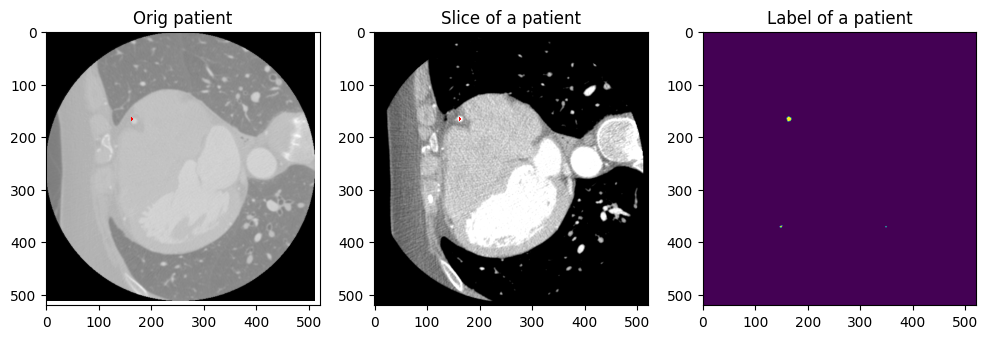

torch.Size([1, 1, 521, 521, 230])


In [25]:
i = 100

import numpy as np
arr = test_patient['label'][0, 0, : ,: , i].numpy().copy()
arr[arr == 0] = np.nan

plt.figure('test', (12, 6))

plt.subplot(1, 3, 1)
plt.title('Orig patient')
plt.imshow(orig_patient['image'][0, 0, : ,: ,i], cmap= "gray")
from matplotlib.colors import LinearSegmentedColormap
cmap = plt.cm.colors.ListedColormap(["red"])
plt.imshow(arr, cmap=cmap)

plt.subplot(1, 3, 2)
plt.title('Slice of a patient')
plt.imshow(test_patient['image'][0, 0, : ,: ,i], cmap= "gray")
plt.imshow(arr, cmap=cmap)

plt.subplot(1,3,3)
plt.title('Label of a patient')
cm = LinearSegmentedColormap.from_list('black_red', [(0, 0, 0), (1, 0, 0)], N=256)
plt.imshow(test_patient['label'][0, 0, : ,: ,i], cmap="viridis")
plt.show()

print(test_patient['image'].shape)